# Analysis of SEIRX model runs for test technology and screening frequency

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import analysis_functions as af

In [2]:
language = 'english' # English or German

In [3]:
# get the right plot labels given the language
metric_name_map = af.label_map[language]['metric_name_map']
frequency_name_map = af.label_map[language]['frequency_name_map']
test_name_map = af.label_map[language]['test_name_map']
index_case_map = af.label_map[language]['index_case_map']
xlabel = af.label_map[language]['xlabels']['testing_strategy']
ylabel = af.label_map[language]['ylabels']['testing_strategy']

if language == 'english':
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']
if language == 'german':
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

## Analysis B.1.1.7

### Data loading and wrangling

In [4]:
res_path = '../data/simulation_results'
plt_dst = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_UK_variant_{}.csv'.format(sim_name, N_runs)))

In [5]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

#### Outbreak sizes

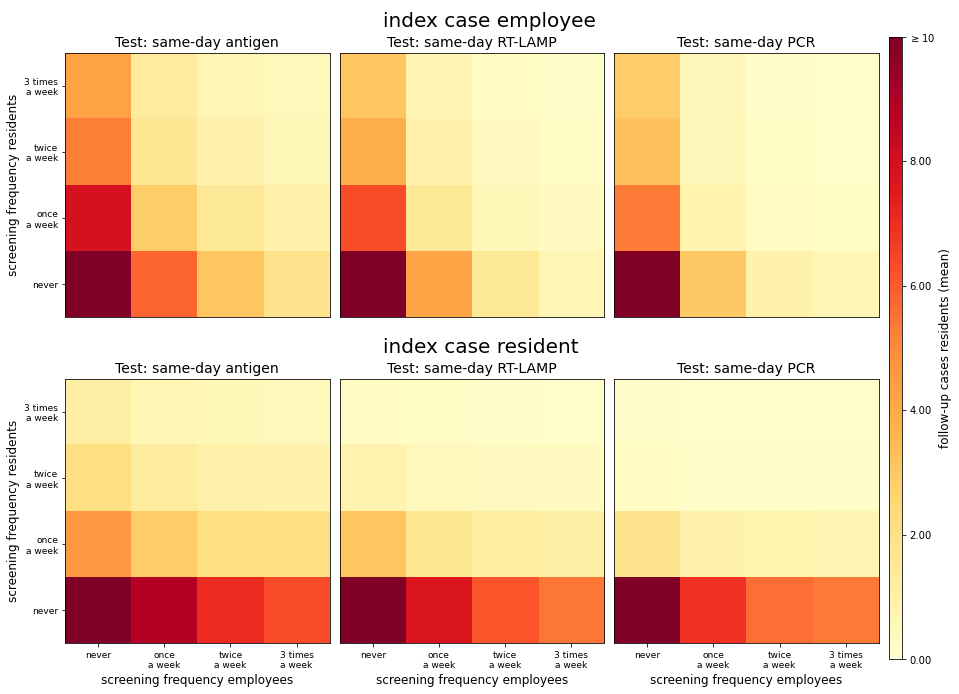

In [6]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_test_technology'
variant = '_UK_variant'
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

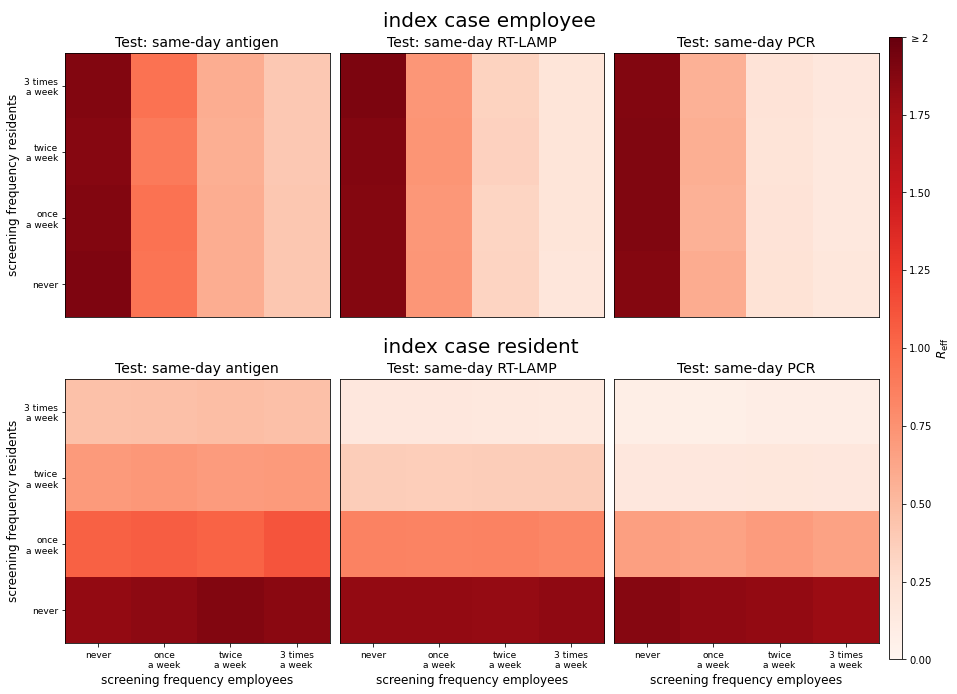

In [7]:
metric = 'R0_mean'
sim_name = 'screening_frequency_test_technology'
fname_addition = '_Reff'
variant = '_UK_variant'
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

#### Test rate

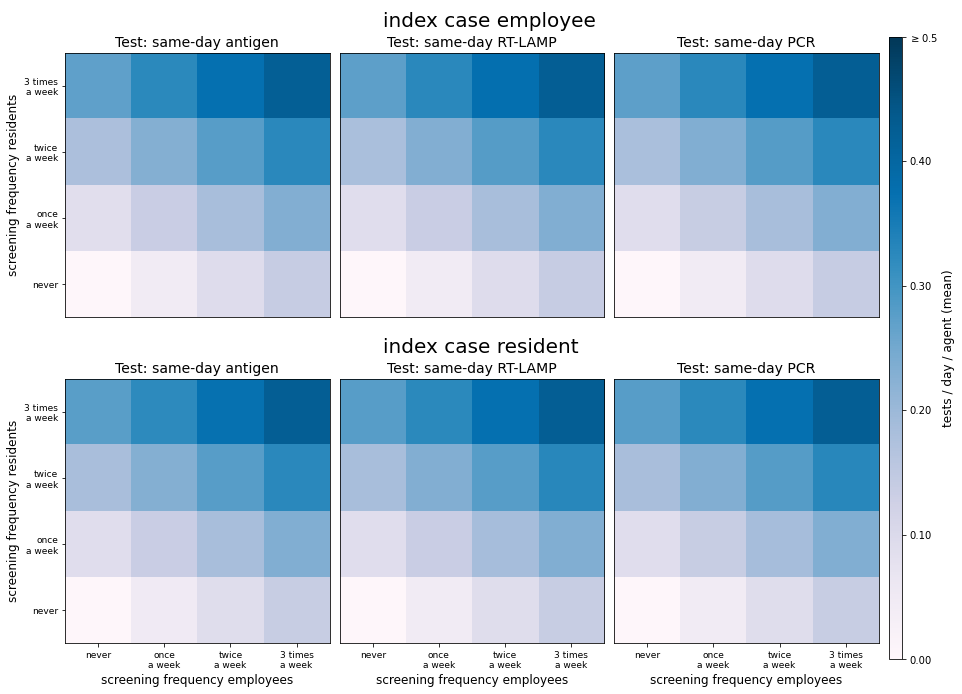

In [8]:
metric = 'test_rate_mean'
sim_name = 'screening_frequency_test_technology'
variant = '_UK_variant'
fname_addition = '_testrate'
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('PuBu')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 0.5
vstep = 0.1

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### PCR: different turnover times

#### Outbreak sizes

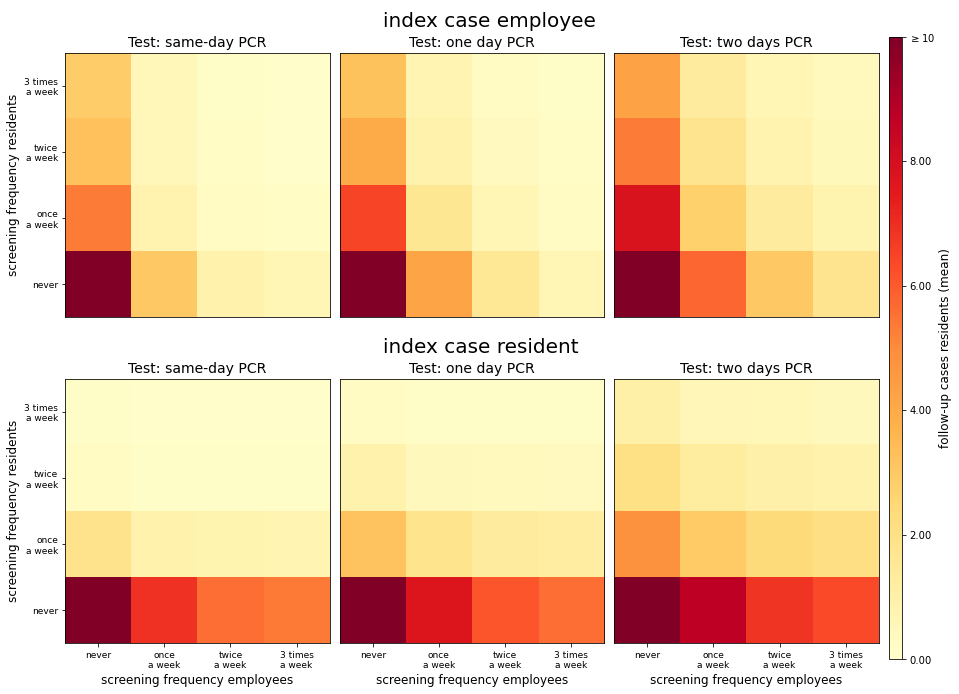

In [9]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
variant = '_UK_variant'
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

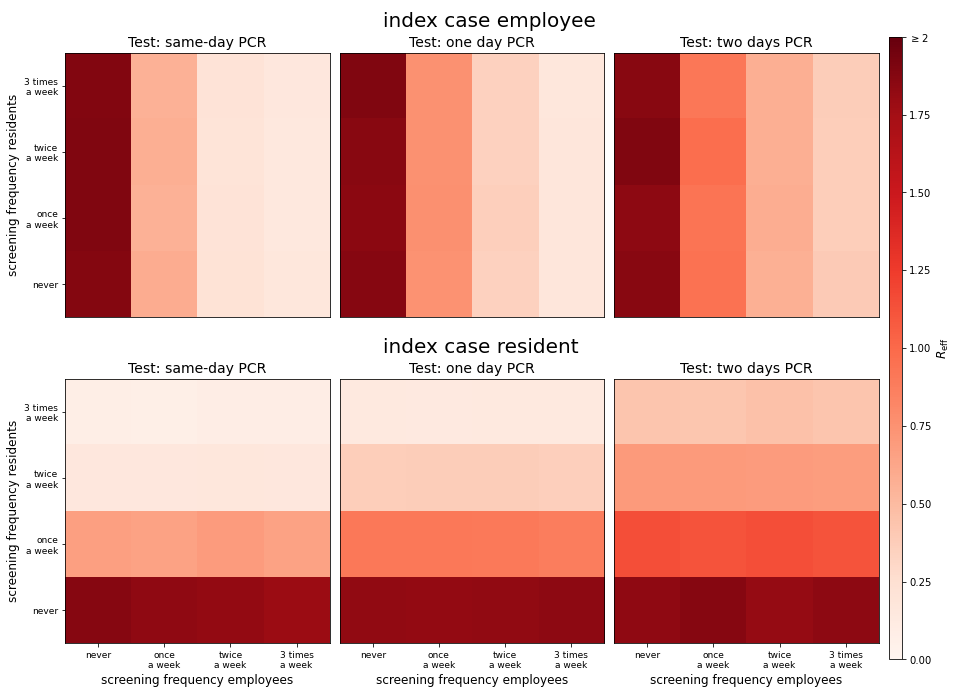

In [10]:
metric = 'R0_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
fname_addition = '_Reff'
variant = '_UK_variant'
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

#### Test rate

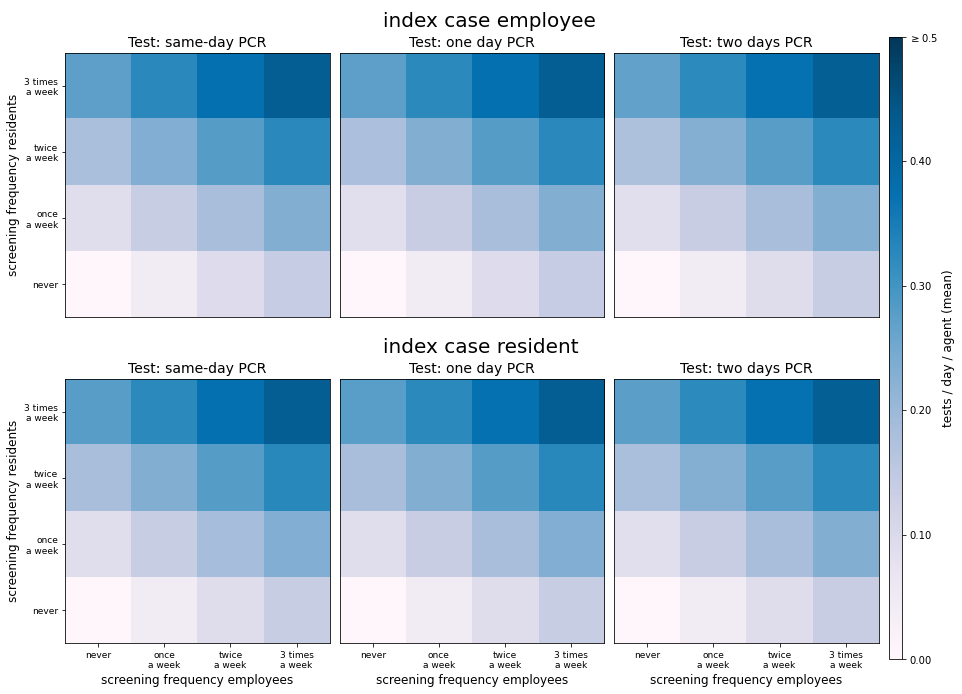

In [11]:
metric = 'test_rate_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
variant = '_UK_variant'
fname_addition = '_testrate'
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('PuBu')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 0.5
vstep = 0.1

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [12]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [13]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.112

In [14]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.4723352835899778

Note: for every test type, there is a scenario where neither employees nor residents are screened. These scenarios are, naturally, the ones with the largest outbreaks. To calculate the outbreak sizes of the largest outbreaks, we therefore average outbreak sizes of all these scenarios:

In [15]:
mean = (data.loc[:, 'never', 'never', 'resident']['infected_residents_mean'] - 1).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

12.45768 +- 11.598686918942535


In [16]:
mean = (data.loc[:, 'never', 'never', 'employee']['infected_residents_mean']).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

13.950199999999999 +- 11.80180583013339


#### Realistic scenario I: employees screened 2x / week

##### Same-day LAMP

In [17]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.493 +- 4.525709602866925


In [18]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.1164 +- 7.630183155009831


##### One-day PCR

In [19]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.5352 +- 4.665180997855126


In [20]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.1144 +- 7.592999629176451


##### Same-day Antigen

In [21]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1212 +- 6.627827410187734


In [22]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.0808 +- 8.294940178597631


##### Same-day PCR

In [23]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9206 +- 3.623661383789174


In [24]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.6054 +- 7.259933344489693


##### Two-day PCR

In [25]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.0296 +- 6.495287645079197


In [26]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.8552 +- 8.174570183167791


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [27]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.0124 +- 6.584323572196364


In [28]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.9508 +- 8.31445761316276


##### Same-day LAMP

In [29]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.1516 +- 7.639835787382581


In [30]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.744 +- 8.835070780426099


##### Same-day Antigen

In [31]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.8106 +- 8.921067465777051


In [32]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.8816 +- 9.408936552948555


#### Two-day PCR

##### Employees 3x / week, residents never 

In [33]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.761 +- 4.928522807841461


In [34]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.339 +- 7.746669037478964


##### Employees 3x / week, residents 1x / week 

In [35]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7846 +- 2.3713556261137003


In [36]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.076 +- 3.560612249588318


##### Employees 3x / week, residents 2x / week 

In [37]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.499 +- 1.3632206989826805


In [38]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8982000000000001 +- 1.8797189759870323


##### Employees 3x / week, residents 3x / week 

In [39]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4168 +- 1.087250745153374


In [40]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.46540000000000004 +- 1.1378320492737366


#### Same-day PCR

In [41]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8422 +- 1.9590984593314011


In [42]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9021999999999999 +- 1.992944938001344


### Test rates

#### Diagnostic testing base rate

In [43]:
mean = data.loc[:, 'never', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.0031218107953171403 +- 0.0022947574606121215


In [44]:
mean = data.loc[:, 'never', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.00318950974555806 +- 0.0021540055697934378


#### Test rates employeed screened 2x / week

In [45]:
mean = data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09228091547759718 +- 0.01221475949105278


In [46]:
mean = data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.091328356074705 +- 0.011424689271757145


#### Test rates residents screened 2x / week

In [47]:
mean = data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.1792613254082594 +- 0.019796836194903935


In [48]:
mean = data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18235107049802404 +- 0.022630450316948342


In [49]:
mean = data.loc[:, 'never', 'twice\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18080619795314168 +- 0.021260903142572826


#### Test rates residents screened 3x / week

In [50]:
mean = data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.2712357655453107 +- 0.02211448219350128


In [51]:
mean = data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27647629476719954 +- 0.02335126592398287


In [52]:
mean = data.loc[:, 'never', '3 times\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27385603015625515 +- 0.02274128341738048


### False negatives

In [53]:
data.loc['same_day_antigen'][['undetected_infections_mean', 'undetected_infections_std']]

undetected_infections_mean  \
employee_screen_interval resident_screen_interval index_case                               
3 times\na week          3 times\na week          employee                        0.0922   
                                                  resident                        0.0798   
                         twice\na week            employee                        0.1018   
                                                  resident                        0.1250   
                         once\na week             employee                        0.1312   
                                                  resident                        0.2180   
                         never                    employee                        0.1040   
                                                  resident                        0.1722   
twice\na week            3 times\na week          employee                        0.1130   
                                                  resident                        0.0964   
                         twice\na week            employee                        0.1228   
                                                  resident                        0.1320   
                         once\na week             employee                        0.1654   
                                                  resident                        0.2252   
                         never                    employee                        0.1448   
                                                  resident                        0.2046   
once\na week             3 times\na week          employee                        0.1760   
                                                  resident                        0.1048   
                         twice\na week            employee                        0.2058   
                                                  resident                        0.1660   
                         once\na week             employee                        0.3090   
                                                  resident                        0.2854   
                         never                    employee                        0.2512   
                                                  resident                        0.2940   
never                    3 times\na week          employee                        0.2140   
                                                  resident                        0.1046   
                         twice\na week            employee                        0.2822   
                                                  resident                        0.1684   
                         once\na week             employee                        0.4206   
                                                  resident                        0.2970   
                         never                    employee                        0.0000   
                                                  resident                        0.0000   

                                                              undetected_infections_std  
employee_screen_interval resident_screen_interval index_case                             
3 times\na week          3 times\na week          employee                     0.315783  
                                                  resident                     0.293000  
                         twice\na week            employee                     0.336837  
                                                  resident                     0.384974  
                         once\na week             employee                     0.420026  
                                                  resident                     0.545651  
                         never                    employee                     0.355541  
                                                  resident                     0.461074  
twice\na week            3 times\

### Results table

#### Employee index case

In [54]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [55]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_UK_variant_employee.csv'))

#### Resident index case

In [56]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [57]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_UK_variant_resident.csv'))

### Preventive testing rates

In [58]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.139328       0.012564
                 resident          0.137295       0.014368
same_day_LAMP    employee          0.140569       0.012699
                 resident          0.137339       0.014243
same_day_PCR     employee          0.139921       0.012509
                 resident          0.137045       0.014500
one_day_PCR      employee          0.139934       0.012788
                 resident          0.136721       0.014928
two_day_PCR      employee          0.137708       0.013686
                 resident          0.135123       0.016039

In [59]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.270688       0.022467
                 resident          0.275819       0.022953
same_day_LAMP    employee          0.272770       0.020601
                 resident          0.277586       0.023518
same_day_PCR     employee          0.273075       0.020658
                 resident          0.277469       0.023503
one_day_PCR      employee          0.271857       0.021562
                 resident          0.277330       0.023458
two_day_PCR      employee          0.267789       0.024988
                 resident          0.274177       0.023321

In [60]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.421587       0.032293
                 resident          0.422320       0.032384
same_day_LAMP    employee          0.422588       0.034843
                 resident          0.422574       0.035325
same_day_PCR     employee          0.421953       0.035848
                 resident          0.422786       0.035616
one_day_PCR      employee          0.422756       0.035246
                 resident          0.421917       0.035772
two_day_PCR      employee          0.420660       0.033576
                 resident          0.420442       0.032677

## Analysis wild-type

### Data loading and wrangling

In [61]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_{}.csv'.format(sim_name, N_runs)))

In [62]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

#### Outbreak sizes

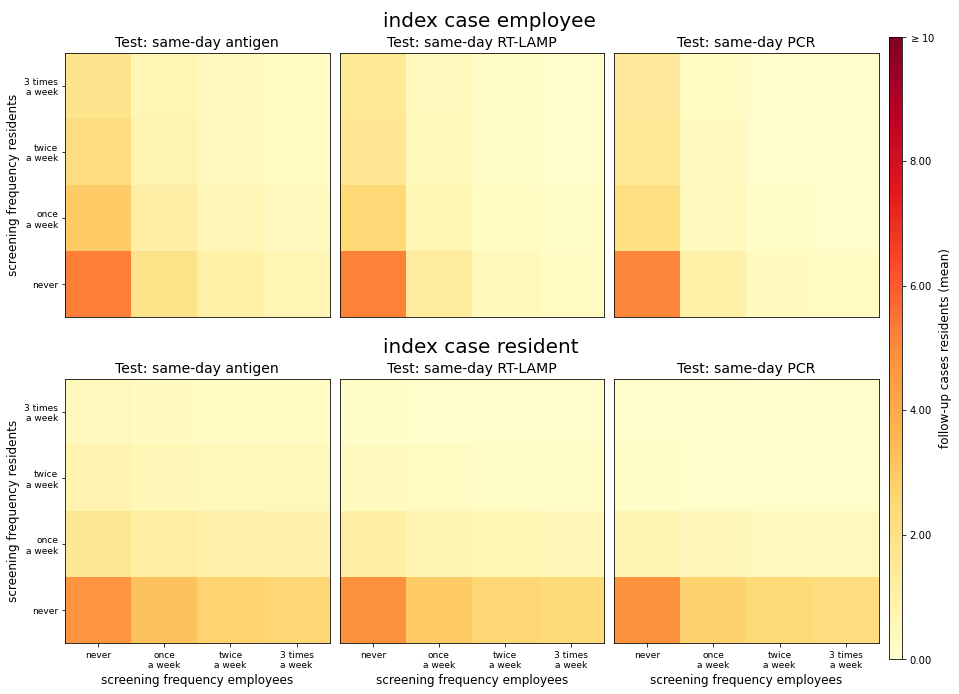

In [63]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_test_technology'
variant = ''
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

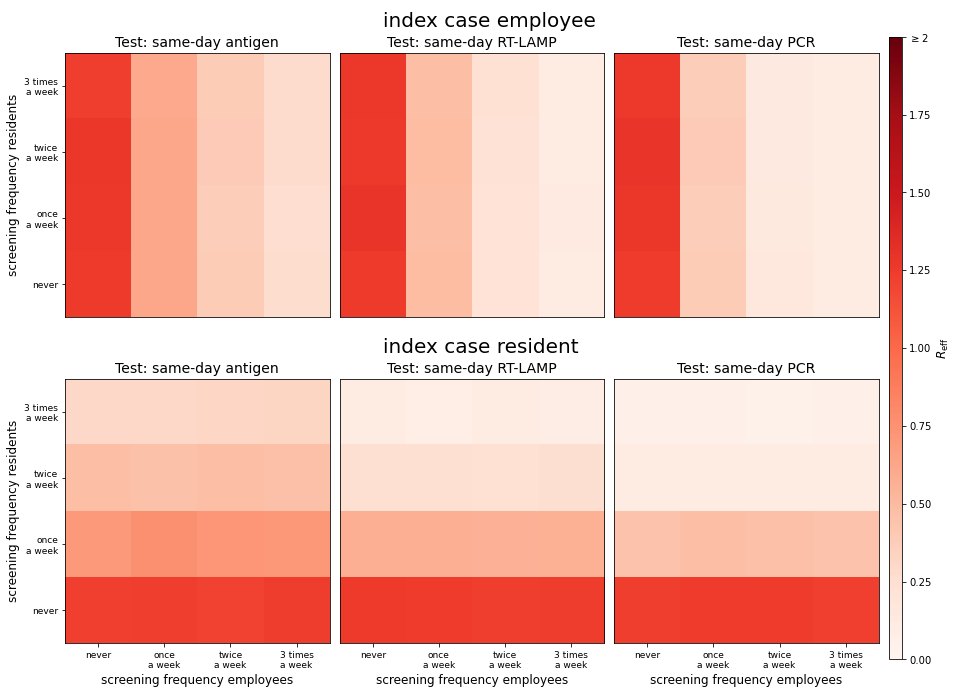

In [64]:
metric = 'R0_mean'
sim_name = 'screening_frequency_test_technology'
fname_addition = '_Reff'
variant = ''
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### PCR: different turnover times

#### Outbreak sizes

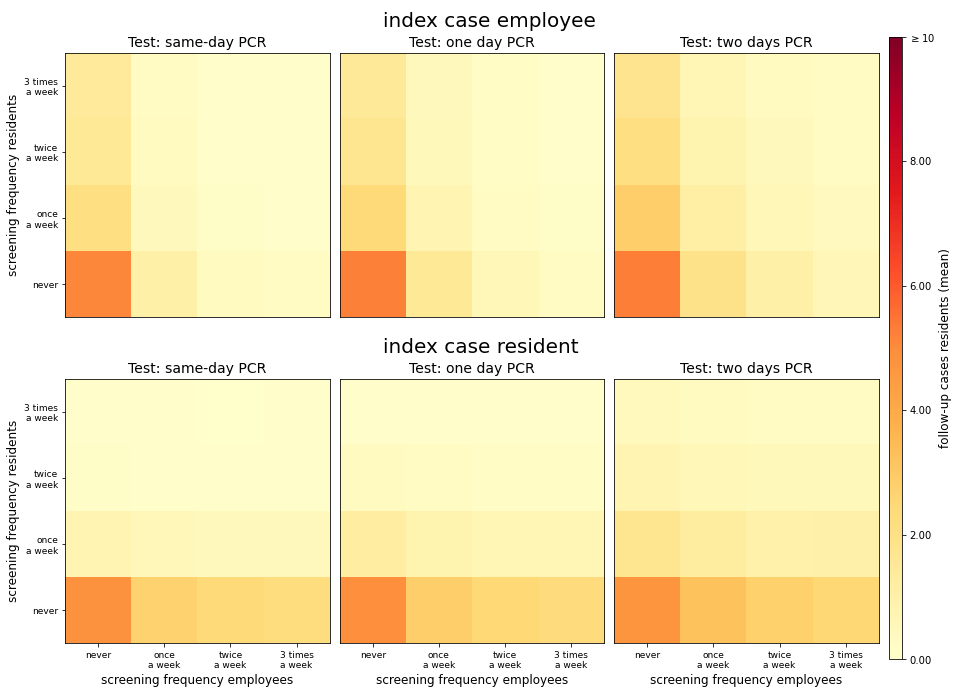

In [66]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
variant = ''
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

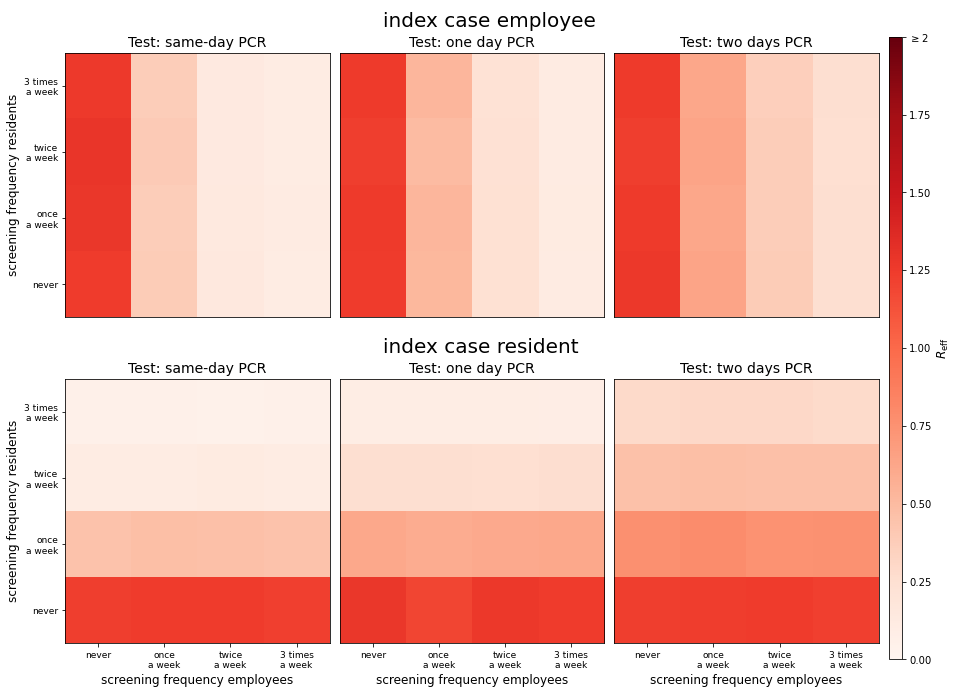

In [67]:
metric = 'R0_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
fname_addition = '_Reff'
variant = ''
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [69]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [70]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.077

In [71]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.3691859418395158

#### Realistic scenario I: employees screened 2x / week

##### Same-day Antigen

In [72]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.0536 +- 2.926848190129719


In [73]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.6638 +- 4.182519366799242


##### Same-day LAMP

In [74]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4998 +- 1.9680382605322957


In [75]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.5748 +- 4.090739760771648


##### One-day PCR

In [76]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.556 +- 2.095171102413757


In [77]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.481 +- 3.934709060029396


##### Same-day PCR

In [78]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3218 +- 1.5745286876134152


In [79]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.408 +- 3.909039794939888


##### Two-day PCR

In [80]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.04 +- 2.8933845812243786


In [81]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.7428 +- 4.269975959995535


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [82]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.04 +- 3.0218249924932867


In [83]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.733 +- 4.330480529031676


##### Same-day LAMP

In [84]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.3498 +- 3.3616216414123707


In [85]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.9946 +- 4.635349839400121


##### Same-day Antigen

In [86]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.9218 +- 4.094708547334904


In [87]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.2042 +- 4.888320928120336


#### Two-day PCR

##### Employees 3x / week, residents never 

In [88]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6218 +- 2.2444091058554565


In [89]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.5026 +- 4.010637141659217


##### Employees 3x / week, residents 1x / week 

In [90]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3672 +- 1.225832245023187


In [91]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9922 +- 1.9456865881379384


##### Employees 3x / week, residents 2x / week 

In [92]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2528 +- 0.8031320963782026


In [93]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4830000000000001 +- 1.0959704513562625


##### Employees 3x / week, residents 3x / week 

In [94]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2384 +- 0.6729457713681247


In [95]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2582 +- 0.6971584941698685


#### Same-day PCR

In [96]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4486 +- 1.1167844382405672


In [97]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5158 +- 1.2316061589429266


### Test rates

#### Diagnostic testing base rate

In [98]:
data.loc[:, 'never', 'never', :]['test_rate_mean'].mean()

0.0017381808017399101

In [99]:
data.loc[:, 'never', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.001491
                  resident      0.001346
same_day_LAMP     employee      0.001514
                  resident      0.001418
same_day_PCR      employee      0.001485
                  resident      0.001390
one_day_PCR       employee      0.001504
                  resident      0.001397
two_day_PCR       employee      0.001530
                  resident      0.001391
Name: test_rate_std, dtype: float64

#### Test rates employeed screened 2x / week

In [100]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.093845
                  resident      0.095594
same_day_LAMP     employee      0.093971
                  resident      0.095240
same_day_PCR      employee      0.093383
                  resident      0.095234
one_day_PCR       employee      0.093373
                  resident      0.095127
two_day_PCR       employee      0.092847
                  resident      0.094701
Name: test_rate_mean, dtype: float64

In [101]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.011188
                  resident      0.009920
same_day_LAMP     employee      0.011835
                  resident      0.010102
same_day_PCR      employee      0.012296
                  resident      0.009814
one_day_PCR       employee      0.011584
                  resident      0.009922
two_day_PCR       employee      0.011550
                  resident      0.010192
Name: test_rate_std, dtype: float64

#### Test rates residents screened 2x / week

In [102]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.184343
                  resident      0.183958
same_day_LAMP     employee      0.184669
                  resident      0.184618
same_day_PCR      employee      0.184418
                  resident      0.184351
one_day_PCR       employee      0.184583
                  resident      0.183724
two_day_PCR       employee      0.183779
                  resident      0.183219
Name: test_rate_mean, dtype: float64

In [103]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.018323
                  resident      0.021399
same_day_LAMP     employee      0.018865
                  resident      0.022646
same_day_PCR      employee      0.018861
                  resident      0.023990
one_day_PCR       employee      0.019296
                  resident      0.022839
two_day_PCR       employee      0.018972
                  resident      0.021389
Name: test_rate_std, dtype: float64

#### Test rates residents screened 3x / week

In [104]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.277843
                  resident      0.277828
same_day_LAMP     employee      0.278143
                  resident      0.277890
same_day_PCR      employee      0.278180
                  resident      0.277800
one_day_PCR       employee      0.277934
                  resident      0.277538
two_day_PCR       employee      0.277050
                  resident      0.276870
Name: test_rate_mean, dtype: float64

In [105]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.019384
                  resident      0.022145
same_day_LAMP     employee      0.019478
                  resident      0.023687
same_day_PCR      employee      0.018951
                  resident      0.023402
one_day_PCR       employee      0.019260
                  resident      0.023446
two_day_PCR       employee      0.020176
                  resident      0.022100
Name: test_rate_std, dtype: float64

### Results table

#### Employee index case

In [106]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [107]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_employee.csv'))

#### Resident index case

In [108]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [109]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_resident.csv'))

### Preventive testing rates

In [110]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141237       0.011595
                 resident          0.142943       0.010776
same_day_LAMP    employee          0.141181       0.011815
                 resident          0.142882       0.010708
same_day_PCR     employee          0.140721       0.012071
                 resident          0.142560       0.010922
one_day_PCR      employee          0.140641       0.012064
                 resident          0.142781       0.010593
two_day_PCR      employee          0.139775       0.011783
                 resident          0.142132       0.010952

In [111]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.277843       0.019384
                 resident          0.277828       0.022145
same_day_LAMP    employee          0.278143       0.019478
                 resident          0.277890       0.023687
same_day_PCR     employee          0.278180       0.018951
                 resident          0.277800       0.023402
one_day_PCR      employee          0.277934       0.019260
                 resident          0.277538       0.023446
two_day_PCR      employee          0.277050       0.020176
                 resident          0.276870       0.022100

In [112]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.422060       0.033179
                 resident          0.422476       0.032642
same_day_LAMP    employee          0.423576       0.035119
                 resident          0.423132       0.035784
same_day_PCR     employee          0.422517       0.035806
                 resident          0.421792       0.036161
one_day_PCR      employee          0.422441       0.035828
                 resident          0.422149       0.035275
two_day_PCR      employee          0.421608       0.034292
                 resident          0.421212       0.033890

## Analysis B.1.1.7 & employee masks

### Data loading and wrangling

In [113]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_masks_{}.csv'.format(sim_name, N_runs)))

In [114]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

#### Outbreak sizes

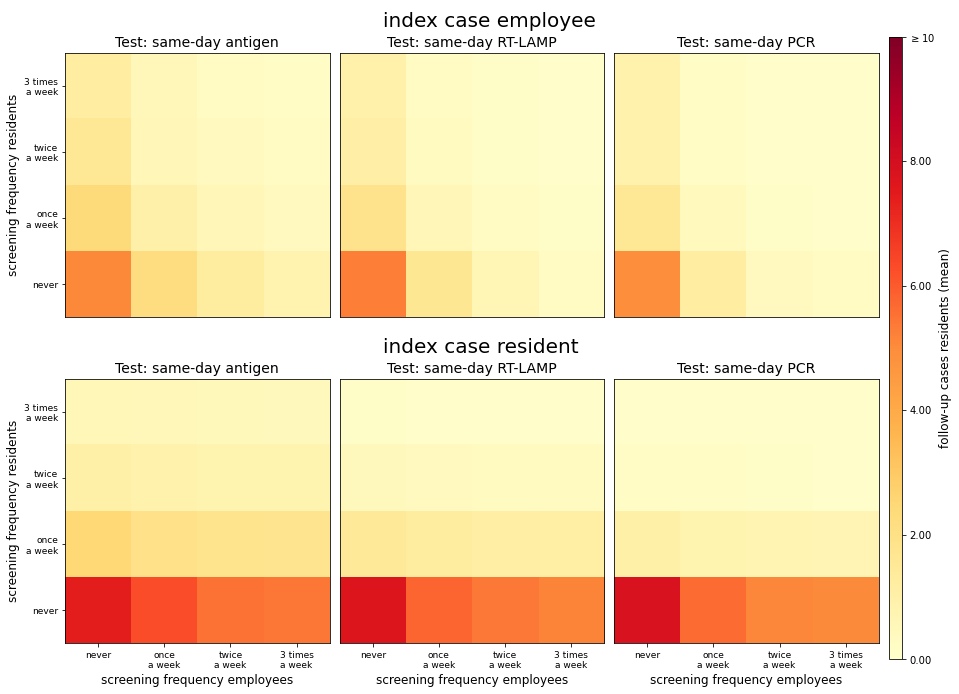

In [115]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_test_technology'
variant = '_masks'
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

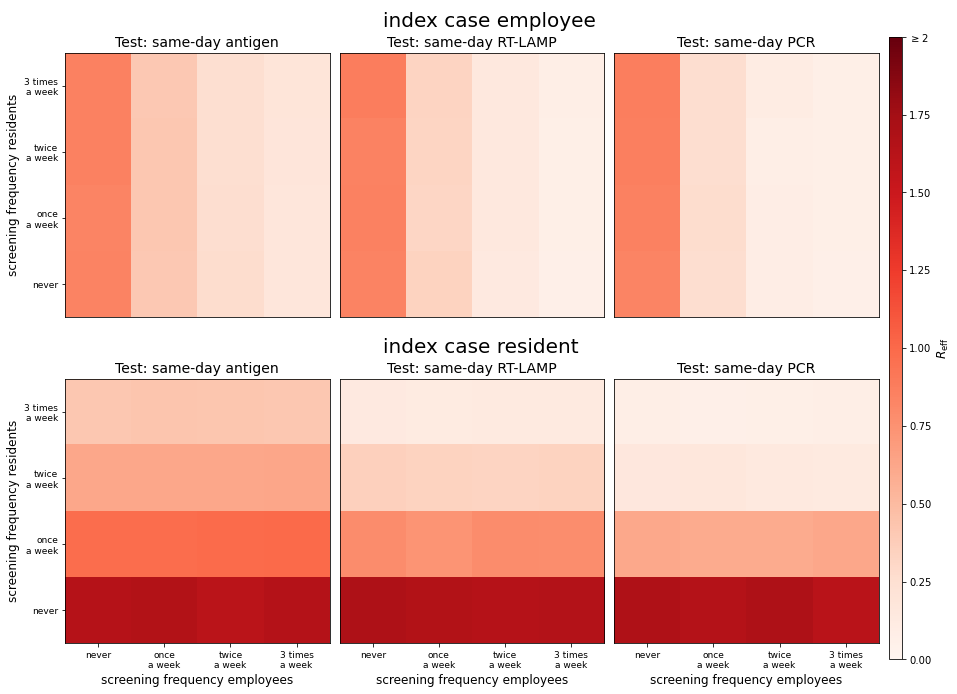

In [116]:
metric = 'R0_mean'
sim_name = 'screening_frequency_test_technology'
fname_addition = '_Reff'
variant = '_masks'
screening_params = screening_intervals
test_types = ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### PCR: different turnover times

#### Outbreak sizes

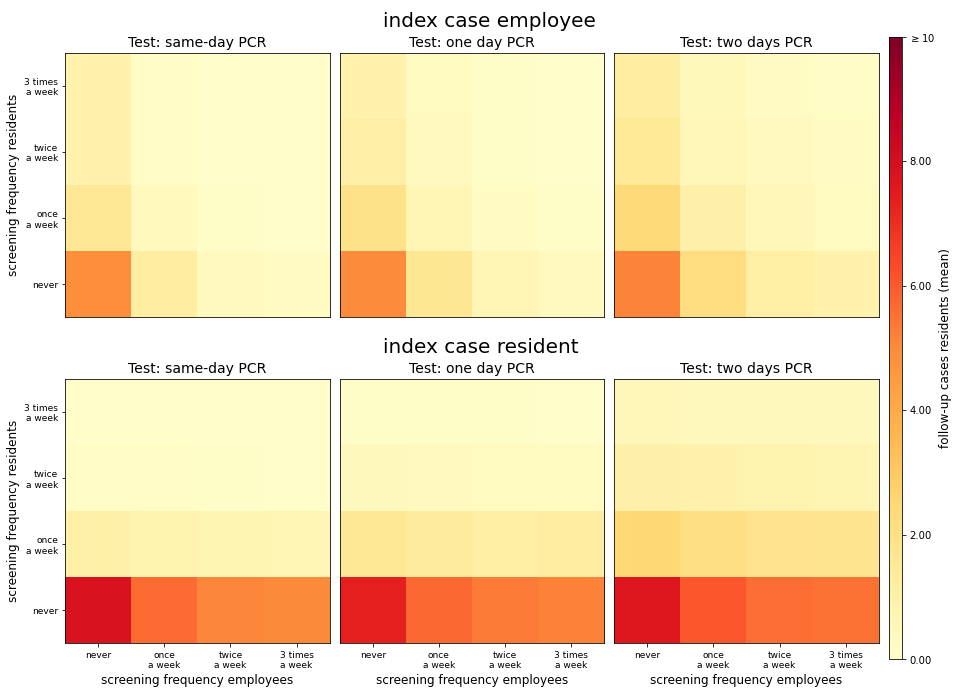

In [117]:
metric = 'infected_residents_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
variant = '_masks'
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('YlOrRd')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst)

#### $R_eff$

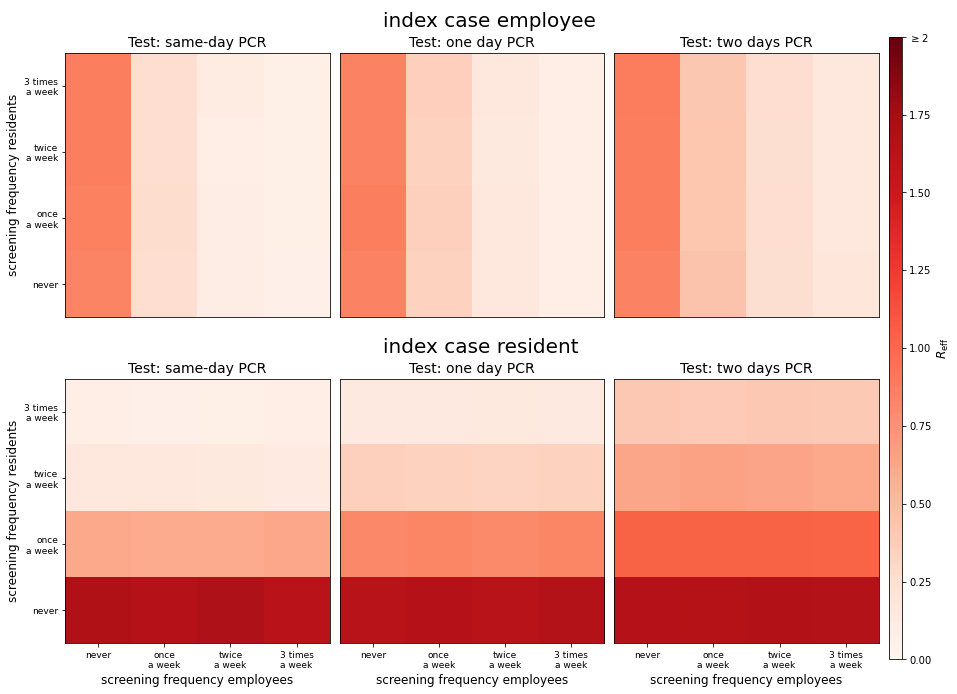

In [118]:
metric = 'R0_mean'
sim_name = 'screening_frequency_PCR_turnover_time'
fname_addition = '_Reff'
variant = '_masks'
screening_params = screening_intervals
test_types = ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']
cmap = plt.get_cmap('Reds')
# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 2
vstep = 0.25

af.plot_testing_strategy_heatmaps(data, metric, test_types, sim_name, 
    screening_params, cmap, vmin, vmax, vstep, language, variant, plt_dst,
    fname_addition)

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [119]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [120]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0596

In [121]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.3060499523193279

Note: for every test type, there is a scenario where neither employees nor residents are screened. These scenarios are, naturally, the ones with the largest outbreaks. To calculate the outbreak sizes of the largest outbreaks, we therefore average outbreak sizes of all these scenarios:

In [122]:
mean = (data.loc[:, 'never', 'never', 'resident']['infected_residents_mean'] - 1).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

7.603 +- 8.796581860386754


In [123]:
mean = (data.loc[:, 'never', 'never', 'employee']['infected_residents_mean']).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

5.10308 +- 8.096327239369305


#### Realistic scenario I: employees screened 2x / week

##### Same-day LAMP

In [124]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6416 +- 2.9562302514283103


In [125]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.3954 +- 7.069728074757204


##### One-day PCR

In [126]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6808 +- 2.99477964147952


In [127]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.3266 +- 6.995063875600047


##### Same-day Antigen

In [128]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2848 +- 4.110847695275848


In [129]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.5294 +- 7.175781072942607


##### Same-day PCR

In [130]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3614 +- 2.193844258493776


In [131]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.1412 +- 6.701092708558637


##### Two-day PCR

In [132]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.1298 +- 3.844984881862132


In [133]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.5974 +- 7.13393943472831


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [134]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.2432 +- 4.146117680235774


In [135]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.6498 +- 7.277235161125279


##### Same-day LAMP

In [136]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.607 +- 4.67740597183151


In [137]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.7976 +- 7.4884878133002255


##### Same-day Antigen

In [138]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.1966 +- 5.462812179032031


In [139]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.2838 +- 7.725930077285959


#### Two-day PCR

##### Employees 3x / week, residents never 

In [140]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.8608 +- 3.4955782316284507


In [141]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.5292 +- 7.080026321599583


##### Employees 3x / week, residents 1x / week 

In [142]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3236 +- 1.3501287381290363


In [143]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.779 +- 3.123477264531376


##### Employees 3x / week, residents 2x / week 

In [144]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2476 +- 0.9833044378642378


In [145]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7616 +- 1.5963944171247295


##### Employees 3x / week, residents 3x / week 

In [146]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1832 +- 0.6475504801363867


In [147]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4356 +- 1.0166904011912254


#### Same-day PCR

In [148]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4138 +- 1.2848734334353673


In [149]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7994000000000001 +- 1.7600509071726214


### Test rates

#### Diagnostic testing base rate

In [150]:
mean = data.loc[:, 'never', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.00145758057117192 +- 0.0016172875138361397


In [151]:
mean = data.loc[:, 'never', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.00239419512098856 +- 0.0016956359480890682


#### Test rates employeed screened 2x / week

In [152]:
mean = data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09365107896716829 +- 0.011869948225538496


In [153]:
mean = data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09403392094159663 +- 0.009847009675710233


#### Test rates residents screened 2x / week

In [154]:
mean = data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.1855386145057401 +- 0.020505114611749087


In [155]:
mean = data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18351997786216784 +- 0.02217128384648161


In [156]:
mean = data.loc[:, 'never', 'twice\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.184529296183954 +- 0.02135445565499414


#### Test rates residents screened 3x / week

In [157]:
mean = data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27966469239711217 +- 0.020183130080247053


In [158]:
mean = data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.2772001446028537 +- 0.022586146734253056


In [159]:
mean = data.loc[:, 'never', '3 times\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27843241849998296 +- 0.021418365532147675


### False negatives

In [160]:
data.loc['same_day_antigen'][['undetected_infections_mean', 'undetected_infections_std']]

undetected_infections_mean  \
employee_screen_interval resident_screen_interval index_case                               
3 times\na week          3 times\na week          employee                        0.0644   
                                                  resident                        0.0848   
                         twice\na week            employee                        0.0756   
                                                  resident                        0.1132   
                         once\na week             employee                        0.0834   
                                                  resident                        0.1564   
                         never                    employee                        0.0722   
                                                  resident                        0.1042   
twice\na week            3 times\na week          employee                        0.0732   
                                                  resident                        0.0916   
                         twice\na week            employee                        0.0832   
                                                  resident                        0.1110   
                         once\na week             employee                        0.0992   
                                                  resident                        0.1814   
                         never                    employee                        0.0916   
                                                  resident                        0.1226   
once\na week             3 times\na week          employee                        0.1004   
                                                  resident                        0.0826   
                         twice\na week            employee                        0.1076   
                                                  resident                        0.1198   
                         once\na week             employee                        0.1318   
                                                  resident                        0.2104   
                         never                    employee                        0.1234   
                                                  resident                        0.1580   
never                    3 times\na week          employee                        0.0620   
                                                  resident                        0.0762   
                         twice\na week            employee                        0.0754   
                                                  resident                        0.1070   
                         once\na week             employee                        0.1120   
                                                  resident                        0.1732   
                         never                    employee                        0.0000   
                                                  resident                        0.0000   

                                                              undetected_infections_std  
employee_screen_interval resident_screen_interval index_case                             
3 times\na week          3 times\na week          employee                     0.254294  
                                                  resident                     0.300711  
                         twice\na week            employee                     0.274043  
                                                  resident                     0.363335  
                         once\na week             employee                     0.311872  
                                                  resident                     0.447190  
                         never                    employee                     0.273865  
                                                  resident                     0.335507  
twice\na week            3 times\

### Results table

#### Employee index case

In [161]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [162]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_masks_employee.csv'))

#### Resident index case

In [163]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [164]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_masks_resident.csv'))

### Preventive testing rates

In [165]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141397       0.012121
                 resident          0.141160       0.011593
same_day_LAMP    employee          0.141285       0.012226
                 resident          0.140734       0.011617
same_day_PCR     employee          0.140866       0.011923
                 resident          0.140405       0.011977
one_day_PCR      employee          0.140582       0.011971
                 resident          0.140351       0.012272
two_day_PCR      employee          0.140183       0.012427
                 resident          0.139850       0.012597

In [166]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.279856       0.020578
                 resident          0.277338       0.021561
same_day_LAMP    employee          0.280157       0.019808
                 resident          0.278135       0.022823
same_day_PCR     employee          0.279711       0.019743
                 resident          0.277583       0.023357
one_day_PCR      employee          0.279966       0.020083
                 resident          0.276788       0.022803
two_day_PCR      employee          0.278633       0.020685
                 resident          0.276157       0.022347

In [167]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.422963       0.034410
                 resident          0.422661       0.032326
same_day_LAMP    employee          0.422985       0.036155
                 resident          0.423269       0.035483
same_day_PCR     employee          0.423081       0.035511
                 resident          0.422694       0.035114
one_day_PCR      employee          0.422814       0.035963
                 resident          0.422352       0.035328
two_day_PCR      employee          0.422198       0.034103
                 resident          0.420784       0.033247